In [1]:
import pyodbc
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### READ DATA 

In [3]:
# conn2 = pyodbc.connect('Driver={SQL Server};'
#                                 'Server=xxxxxx.cahwy5xxx.us-east-1.rds.amazonaws.com,xxxx;'
#                                 'Database=Charity;'
#                                 'uid=xxxxx;pwd=xxxxxxx')
# print ("Connected")
# cursor = conn2.cursor()


In [4]:
# query = '''
#          SELECT *
#          FROM campaign_data
#        '''

# df = pd.read_sql_query(query, con= conn2)

In [5]:
#df.to_csv('campaign data.csv', index = False)

In [6]:
df = pd.read_csv('campaign_data.csv')

In [7]:
df.head(2)

,serial_no,Ad_Group,Search_Keyword,Quality_Score,Ad_relevance_Score,Expected_CTR_Score,Landing_page_exp_Score,Ad_relevance,Expected_CTR,Landing_page_experience,Avg_position,Impressions,Clicks,Total_Cost,Conversions,Revenue_per_unit_sold,Total_Revenue
0,0,Gifts and Banker Products,rorys story cubes,3,0,0.0,1.75,Below average,Below average,Average,7,1935,39,12.90,1,9.99,12.72
1,1,Gifts and Banker Products,gosh christmas frankincense candle,10,2,3.5,3.50,Above average,Above average,Above average,2,28400,1893,189.33,186,25.00,4658.37


In [8]:
df.columns = ['index', 'Ad_Group', 'Search_Keyword', 'Quality_score', 'Ad_relevance_score',
            'Expected_CTR_score', 'Landing_page_exp_score', 'Ad_relevance',
            'Expected_clickthrough_rate', 'Landing_page_experience', 'Avg_position',
             'Impressions', 'Clicks', 'Total_Cost', 'Conversions', 'Revenue_per_unit_sold', 'Total_Revenue']

In [9]:
df = df[['Ad_Group', 'Search_Keyword', 'Quality_score', 'Ad_relevance',
       'Expected_clickthrough_rate', 'Landing_page_experience', 'Ad_relevance_score',
       'Expected_CTR_score', 'Landing_page_exp_score', 'Avg_position', 'Impressions', 'Clicks', 
      'Total_Cost', 'Conversions', 'Revenue_per_unit_sold', 'Total_Revenue']]

### CHANGE AVERAGE POSITION ORDER FROM 1(highest - 10(lowest) TO 10(highest) to 1(lowest)

In [10]:
avg_position = df['Avg_position'].unique()
position_score = [4, 9, 10, 2, 1, 6, 7, 3, 5, 8]
df['position_score'] = df['Avg_position'].map(dict(zip(avg_position, position_score)))

In [11]:
df = df.drop('Avg_position', axis = 1)

In [12]:
df.head(2)

,Ad_Group,Search_Keyword,Quality_score,Ad_relevance,Expected_clickthrough_rate,Landing_page_experience,Ad_relevance_score,Expected_CTR_score,Landing_page_exp_score,Impressions,Clicks,Total_Cost,Conversions,Revenue_per_unit_sold,Total_Revenue,position_score
0,Gifts and Banker Products,rorys story cubes,3,Below average,Below average,Average,0,0.0,1.75,1935,39,12.90,1,9.99,12.72,4
1,Gifts and Banker Products,gosh christmas frankincense candle,10,Above average,Above average,Above average,2,3.5,3.50,28400,1893,189.33,186,25.00,4658.37,9


### SPLIT DATA TO TRAINING AND TEST DATA FOR MODELING

In [13]:
features = list(df.columns.drop('Conversions'))

X = df[features]
y = df['Conversions']

In [14]:
from sklearn.model_selection import train_test_split
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= SEED)

In [15]:
training_df = pd.concat([X_train, y_train], axis = 1)

test_df = pd.concat([X_test, y_test], axis = 1)

In [16]:
keywords = test_df[['Ad_Group', 'Search_Keyword']]
keywords = keywords.reset_index().drop('index', axis = 1)

### Effect of Factors Affecting Quality Score

#### Pearson correlation matrix of Quality Score and its Factors

In [17]:
df_qs = df[['Quality_score', 'Ad_relevance_score',
       'Expected_CTR_score', 'Landing_page_exp_score']]

<AxesSubplot:>

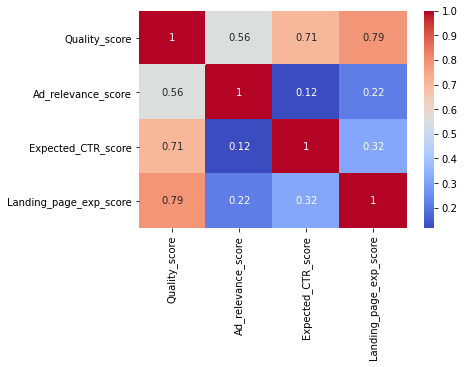

In [18]:
sns.heatmap(df_qs.corr(), annot = True, cmap = 'coolwarm')

In [19]:
from statsmodels.formula.api import ols

model = ols('Quality_score ~ Ad_relevance_score + Expected_CTR_score +\
                    Landing_page_exp_score + 0', data = training_df).fit()

In [20]:
print(f"{model.params} \n") 
print(f"rsquared: {model.rsquared}")

Ad_relevance_score        1.273957
Expected_CTR_score        1.419437
Landing_page_exp_score    0.902590
dtype: float64 

rsquared: 0.9900136293076974


### Effect of Quality score on Average Ad position

In [21]:
model2 = ols('position_score ~ Quality_score + 0', data = training_df).fit()

In [22]:
print(f"{model2.params} \n") 
print(f"rsquared: {model2.rsquared}")

Quality_score    0.99755
dtype: float64 

rsquared: 0.8602117028958625


### Effect of Average position on Impressions

In [23]:
model3 = ols('Impressions ~ Ad_Group:position_score + 0', data = training_df).fit()

In [24]:
print(f"{model3.params} \n") 
print(f"rsquared: {model3.rsquared}")

Ad_Group[Alternative Gifts]:position_score            1908.181416
Ad_Group[Books]:position_score                        2975.863636
Ad_Group[Children's Clothes]:position_score           1288.330097
Ad_Group[Christmas Cards]:position_score              1034.415205
Ad_Group[Gifts and Banker Products]:position_score    1998.605373
Ad_Group[Marketing]:position_score                    3472.000000
dtype: float64 

rsquared: 0.7413736872336099


### Effect of Impressions on Clicks

In [25]:
model4 = ols('Clicks ~ Ad_Group:Impressions + 0', data = training_df).fit()

In [26]:
print(f"{model4.params} \n") 
print(f"rsquared: {model4.rsquared}")

Ad_Group[Alternative Gifts]:Impressions            0.046675
Ad_Group[Books]:Impressions                        0.039186
Ad_Group[Children's Clothes]:Impressions           0.033180
Ad_Group[Christmas Cards]:Impressions              0.033635
Ad_Group[Gifts and Banker Products]:Impressions    0.055237
Ad_Group[Marketing]:Impressions                    0.026642
dtype: float64 

rsquared: 0.9651159113833189


### Effect of Clicks on Conversions

In [27]:
model5 = ols('Conversions ~ Ad_Group:Clicks + 0', data = training_df).fit()

In [28]:
print(f"{model5.params} \n") 
print(f"rsquared: {model5.rsquared}")

Ad_Group[Alternative Gifts]:Clicks            0.070112
Ad_Group[Books]:Clicks                        0.060380
Ad_Group[Children's Clothes]:Clicks           0.049703
Ad_Group[Christmas Cards]:Clicks              0.054839
Ad_Group[Gifts and Banker Products]:Clicks    0.088262
Ad_Group[Marketing]:Clicks                    0.037838
dtype: float64 

rsquared: 0.9777787508691803


### Chisquare Test of Independence between Ad Groups and Landing Page experince

In [29]:
df['Ad_Group'].unique()

array(['Gifts and Banker Products', 'Marketing', "Children's Clothes",
       'Books', 'Christmas Cards', 'Alternative Gifts'], dtype=object)

In [30]:
ad_group_relevance = df.groupby('Ad_Group')['Landing_page_experience'].value_counts(normalize = True).unstack()
ad_group_relevance

Landing_page_experience,Above average,Average,Below average
Ad_Group,,,
Alternative Gifts,NaN,0.500000,0.500000
Books,NaN,0.571429,0.428571
Children's Clothes,NaN,0.200000,0.800000
Christmas Cards,NaN,0.048387,0.951613
Gifts and Banker Products,0.298507,0.208955,0.492537
Marketing,NaN,NaN,1.000000


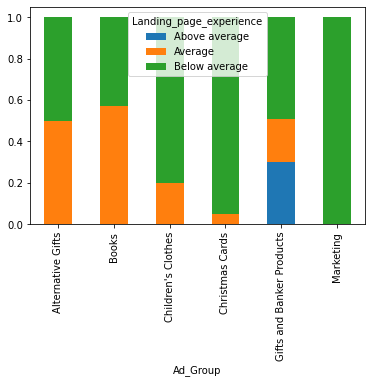

In [31]:
ad_group_relevance.plot(kind='bar', stacked=True) 
plt.show()

In [32]:
import pingouin

In [33]:
expected, observed, stat = pingouin.chi2_independence(data = df, x = 'Ad_Group', y = 'Landing_page_experience')

C:\Users\tuneG\anaconda3\lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
C:\Users\tuneG\anaconda3\lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
C:\Users\tuneG\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:6775: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\tuneG\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:6775: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\tuneG\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:6772: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


In [34]:
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,50.379197,10.0,2.272914e-07,0.415369,0.957056
1,cressie-read,0.666667,50.295546,10.0,2.354963e-07,0.415024,0.956712
2,log-likelihood,0.000000,56.272902,10.0,1.824876e-08,0.438994,0.975902
3,freeman-tukey,-0.500000,NaN,10.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.000000,inf,10.0,0.000000e+00,inf,1.000000
5,neyman,-2.000000,NaN,10.0,NaN,NaN,NaN


### Predicting Ads Keyword Conversions

#### Preprocessing

In [35]:
training_df.head(3)

,Ad_Group,Search_Keyword,Quality_score,Ad_relevance,Expected_clickthrough_rate,Landing_page_experience,Ad_relevance_score,Expected_CTR_score,Landing_page_exp_score,Impressions,Clicks,Total_Cost,Revenue_per_unit_sold,Total_Revenue,position_score,Conversions
124,Christmas Cards,ho ho ho santa christmas card,5,Above average,Average,Below average,2,1.75,0.0,10825,361,72.17,3.00,54.86,7,18
51,Gifts and Banker Products,posting christmas stocking gift bag large,7,Average,Average,Above average,1,1.75,3.5,24206,1130,161.37,1.40,110.06,9,79
42,Gifts and Banker Products,love life amazing dad keyring,3,Below average,Average,Below average,0,1.75,0.0,1764,35,11.76,2.99,3.27,3,1


In [36]:
training_df = training_df[['Ad_Group', 'Quality_score',  'Ad_relevance_score', 'Expected_CTR_score', 'Landing_page_exp_score',
          'position_score', 'Impressions', 'Clicks', 'Conversions']]

test_df = test_df[['Ad_Group', 'Quality_score',  'Ad_relevance_score', 'Expected_CTR_score', 'Landing_page_exp_score',
          'position_score', 'Impressions', 'Clicks', 'Conversions']]


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE

In [38]:
cat_columns = ['Ad_Group']

In [39]:
def one_hot_encoding(training_df):
    from sklearn.preprocessing import OneHotEncoder
    
    ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
    ohe.fit(training_df[cat_columns])
    
    cat_ohe = ohe.transform(training_df[cat_columns])
    ohe_training_df = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = cat_columns))

    training_df.reset_index(inplace= True)
    training_df.drop('index', axis= 1, inplace= True)

    training_df_encoded = pd.concat([training_df, ohe_training_df], axis=1).drop(columns = cat_columns, axis=1)
    
    return ohe, training_df_encoded

In [40]:
encoder, training_df_encoded =  one_hot_encoding(training_df)
#pickle.dump(encoder, open('Fitted_OneHotencoder.pkl', 'wb'))

def encode_new_data(new_data_df):
    cat_ohe_new = encoder.transform(new_data_df[cat_columns])
    ohe_new_data_df = pd.DataFrame(cat_ohe_new, columns = encoder.get_feature_names_out(input_features = cat_columns))
    
    new_data_df.reset_index(inplace= True)
    new_data_df.drop('index', axis= 1, inplace= True)
    
    new_data_df_encoded = pd.concat([new_data_df, ohe_new_data_df], axis=1).drop(columns = cat_columns, axis=1)
    return new_data_df_encoded



C:\Users\tuneG\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tuneG\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [41]:
test_df_encoded = encode_new_data(test_df)

In [42]:
features = list(training_df_encoded.columns.drop('Conversions'))

X_train = training_df_encoded[features]
y_train = training_df_encoded['Conversions']

X_test = test_df_encoded[features]
y_test = test_df_encoded['Conversions']

#### Fitting and Evaluating Linear Regression Model

In [43]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)

In [44]:
y_pred = model.predict(X_test)

In [45]:
MAE(y_test, y_pred)

1.7861312060233763

### Sample Tweaking of 'Quality Score' factor(s) (Expected_CTR_score) to see the effect on Conversions

In [46]:
X_test.loc[26,:]

Quality_score                             7.00
Ad_relevance_score                        2.00
Expected_CTR_score                        1.75
Landing_page_exp_score                    1.75
position_score                            8.00
Impressions                           15533.00
Clicks                                  725.00
Ad_Group_Alternative Gifts                1.00
Ad_Group_Books                            0.00
Ad_Group_Children's Clothes               0.00
Ad_Group_Christmas Cards                  0.00
Ad_Group_Gifts and Banker Products        0.00
Ad_Group_Marketing                        0.00
Name: 26, dtype: float64

In [47]:
print(f"Current Conversions for Ad_keyword above: {y_test.loc[26]}")

Current Conversions for Ad_keyword above: 51


Increased the Expected_CTR_score by one unit to 3.5

In [48]:
dataa = {'Quality_score': [8], 'Ad_relevance_score':[2], 'Expected_CTR_score':[3.5],
       'Landing_page_exp_score': [1.75], 'position_score':[9], 'Impressions':[17448], 'Clicks':[814],
       'Ad_Group_Alternative Gifts': [1], 'Ad_Group_Books': [0],
       "Ad_Group_Children's Clothes":[0], 'Ad_Group_Christmas Cards':[0],
       'Ad_Group_Gifts and Banker Products':[0], 'Ad_Group_Marketing':[0]}

In [49]:
new_data = pd.DataFrame(dataa)

In [50]:
new_data

,Quality_score,Ad_relevance_score,Expected_CTR_score,Landing_page_exp_score,position_score,Impressions,Clicks,Ad_Group_Alternative Gifts,Ad_Group_Books,Ad_Group_Children's Clothes,Ad_Group_Christmas Cards,Ad_Group_Gifts and Banker Products,Ad_Group_Marketing
0,8,2,3.5,1.75,9,17448,814,1,0,0,0,0,0


In [51]:
print(f"New Conversions count after increasing Expected_CTR_score of keyword: {model.predict(new_data)[0]}")

New Conversions count after increasing Expected_CTR_score of keyword: 54.37528644478394


### AUTOMATING QUALITY SCORE FACTOR(S) TWEAKS

#### USING RESULTING QUALITY SCORE, AVERAGE POSITION SCORE, NUMBER OF IMPRESSIONS AND CLICKS
#### TO _PREDICT NUMBER OF CONVERSIONS_    

### FUNCTION TO CHANGE QUALITY SCORE BY IMPROVING ONE OR MORE FACTOR

In [52]:
def change_Qualityscore(row, factor = None, change = None):
    model = ols('Quality_score ~ Ad_relevance_score + Expected_CTR_score +\
                        Landing_page_exp_score + 0', data = df).fit()
    qs = row['Quality_score']
    if factor == 'Ad_relevance':
        if change == 'improve':
            if qs < 10:
                qs += model.params['Ad_relevance_score']
                return round(qs)
            else:
                return qs
        elif change == 'recede':
            if qs > 0:
                qs -= model.params['Ad_relevance_score']
                return round(qs)
            else:
                return qs
        
    elif factor == 'Expected_clickthrough_rate':
        if change == 'improve':
            if qs < 10:
                qs += model.params['Expected_CTR_score']
                return round(qs)
            else:
                return qs
        elif change == 'recede':
            if qs > 0:
                qs -= model.params['Expected_CTR_score']
                return round(qs)
            else:
                return qs
        
    elif factor == 'Landing_page_experience':
        if change == 'improve':
            if qs < 10:
                qs += model.params['Landing_page_exp_score']
                return round(qs)
            else:
                return qs
        elif change == 'recede':
            if qs > 0:
                qs -= model.params['Landing_page_exp_score']
                return round(qs)
            else:
                return qs
    
    else:
        return qs

In [53]:
change_Qualityscore(X_test.loc[17,:] ,'Landing_page_experience', 'recede')

1

### FUNCTION TO IMPROVE OR RECEDE AVERAGE AD POSITION

In [54]:
def change_ADposition(row, factor, change):
    
    current_qs = row['Quality_score']
    current_position = row['position_score'] 
    new_qs = change_Qualityscore(row, factor, change)
    model2 = ols('position_score ~ Quality_score + 0', data = df).fit()
    
    if new_qs > current_qs:
        if current_position < 10:
            current_position += model2.params['Quality_score']
            return round(current_position)
        else:
            return current_position
    
    elif new_qs < current_qs:
        if current_position > 0:
            current_position -= model2.params['Quality_score']
            return round(current_position)
        else:
            return current_position
    
    elif new_qs == current_qs:
        return current_position

In [55]:
change_ADposition(X_test.loc[17,:], 'Landing_page_experience', 'recede')

3

### FUNCTION TO CHANGE IMPRESSIONS

In [56]:
def change_Impressions(row, ad_group, factor, change_type):
    model3 = ols('Impressions ~ Ad_Group:position_score + 0', data = df).fit()
    
    current_position = row['position_score']
    new_position = change_ADposition(row, factor, change_type)
    impressions = row['Impressions']
    if ad_group == 'Alternative Gifts':
        if new_position > current_position:
            impressions += model3.params['Ad_Group[Alternative Gifts]:position_score']
            return round(impressions)
        elif new_position < current_position:
            impressions -= model3.params['Ad_Group[Alternative Gifts]:position_score']
            return round(impressions)
        elif new_position == current_position:
            return impressions

        
    elif ad_group == 'Books':
        if new_position > current_position:
            impressions += model3.params['Ad_Group[Books]:position_score']
            return round(impressions)
        elif new_position < current_position:
            impressions -= model3.params['Ad_Group[Books]:position_score']
            return round(impressions)
        elif new_position == current_position:
            return impressions
        
    elif ad_group == "Children's Clothes":
        if new_position > current_position:
            impressions += model3.params["Ad_Group[Children's Clothes]:position_score"]
            return round(impressions)
        elif new_position < current_position:
            impressions -= model3.params["Ad_Group[Children's Clothes]:position_score"]
            return round(impressions)
        elif new_position == current_position:
            return impressions
        
    elif ad_group == "Christmas Cards":
        if new_position > current_position:
            impressions += model3.params["Ad_Group[Christmas Cards]:position_score"]
            return round(impressions)
        elif new_position < current_position:
            impressions -= model3.params["Ad_Group[Christmas Cards]:position_score"]
            return round(impressions)
        elif new_position == current_position:
            return impressions
        
    elif ad_group == "Gifts and Banker Products":
        if new_position > current_position:
            impressions += model3.params["Ad_Group[Gifts and Banker Products]:position_score"]
            return round(impressions)
        elif new_position < current_position:
            impressions -= model3.params["Ad_Group[Gifts and Banker Products]:position_score"]
            return round(impressions)
        elif new_position == current_position:
            return impressions
        
    elif ad_group == "Marketing":
        if new_position > current_position:
            impressions += model3.params["Ad_Group[Marketing]:position_score"]
            return round(impressions)
        elif new_position < current_position:
            impressions -= model3.params["Ad_Group[Marketing]:position_score"]
            return round(impressions)
    elif new_position == current_position:
            return impressions
        
        
    


In [57]:
change_Impressions(X_test.loc[17,:], 'Books', 'Landing_page_experience', 'recede')

-1537

In [58]:
X_test.loc[17,:]

Quality_score                            2.0
Ad_relevance_score                       1.0
Expected_CTR_score                       0.0
Landing_page_exp_score                   0.0
position_score                           4.0
Impressions                           1020.0
Clicks                                  14.0
Ad_Group_Alternative Gifts               0.0
Ad_Group_Books                           1.0
Ad_Group_Children's Clothes              0.0
Ad_Group_Christmas Cards                 0.0
Ad_Group_Gifts and Banker Products       0.0
Ad_Group_Marketing                       0.0
Name: 17, dtype: float64

### FUNCTION TO CHANGE CLICKS

In [59]:
def change_Clicks(row, ad_group, factor, change_type):
    model4 = ols('Clicks ~ Ad_Group:Impressions + 0', data = df).fit()
    
    current_clicks = row['Clicks']
    current_impressions = row['Impressions']
    new_impressions = change_Impressions(row, ad_group, factor, change_type)
    
    if ad_group == 'Alternative Gifts':
        if new_impressions > current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks = current_clicks + impressions_change * model4.params['Ad_Group[Alternative Gifts]:Impressions']
            return round(clicks)
        elif new_impressions < current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks_change = impressions_change * model4.params['Ad_Group[Alternative Gifts]:Impressions']
            return current_clicks - abs(clicks_change)

        elif new_impressions == current_impressions:
            return round(current_clicks)
        
        
    elif ad_group == 'Books':
        if new_impressions > current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks = current_clicks + impressions_change * model4.params['Ad_Group[Books]:Impressions']
            return round(clicks)
        elif new_impressions < current_impressions:
            impressions_change = new_impressions -  current_impressions
            clicks_change = impressions_change * model4.params['Ad_Group[Books]:Impressions']
            return current_clicks - abs(clicks_change)

        elif new_impressions == current_impressions:
            return round(current_clicks)
        
        
    elif ad_group == "Children's Clothes":
        if new_impressions > current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks = current_clicks + impressions_change  * model4.params["Ad_Group[Children's Clothes]:Impressions"]
            return round(clicks)
        elif new_impressions < current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks_change = impressions_change  * model4.params["Ad_Group[Children's Clothes]:Impressions"]
            return current_clicks - abs(clicks_change)

        elif new_impressions == current_impressions:
            return round(current_clicks)
        
        
        
    elif ad_group == "Christmas Cards":
        if new_impressions > current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks = current_clicks + impressions_change * model4.params["Ad_Group[Christmas Cards]:Impressions"]
            return round(clicks)
        elif new_impressions < current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks_change = impressions_change * model4.params["Ad_Group[Christmas Cards]:Impressions"]
            return current_clicks - abs(clicks_change)

        elif new_impressions == current_impressions:
            return round(current_clicks)
        
        
    elif ad_group == "Gifts and Banker Products":
        if new_impressions > current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks = current_clicks + impressions_change * model4.params["Ad_Group[Gifts and Banker Products]:Impressions"]
            return round(clicks)
        elif new_impressions < current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks_change = impressions_change * model4.params["Ad_Group[Gifts and Banker Products]:Impressions"]
            return current_clicks - abs(clicks_change)

        elif new_impressions == current_impressions:
            return round(current_clicks)
        
    elif ad_group == "Marketing":
        if new_impressions > current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks =  current_clicks + impressions_change * model4.params["Ad_Group[Marketing]:Impressions"]
            return round(clicks)
        elif new_impressions < current_impressions:
            impressions_change = new_impressions - current_impressions
            clicks_change = impressions_change * model4.params["Ad_Group[Marketing]:Impressions"]
            return current_clicks - abs(clicks_change)

        elif new_impressions == current_impressions:
            return round(current_clicks)

In [60]:
change_Clicks(X_test.loc[17,:], 'Books', 'Landing_page_experience', 'recede')

-86.13052487492963

### CLASS TO UPDATE METRICS BASED ON QUALITY SCORE FACTOR(S) CHANGE

In [61]:
class changeQs:
    
    def __init__(self, current_row):
        self.current_row = current_row
    
    def change_one_factor(self, change_factor, change_type, ad_group):
        if change_type == 'improve':
            new_row = {'Quality_score': change_Qualityscore(self.current_row , change_factor, change_type),
                       'Ad_relevance_score': [self.current_row['Ad_relevance_score'] + 1 if change_factor == 'Ad_relevance' and\
                                              self.current_row['Ad_relevance_score'] < 2 else self.current_row['Ad_relevance_score']][0],
                       'Expected_CTR_score': [self.current_row['Expected_CTR_score'] + 1.75 if change_factor == 'Expected_clickthrough_rate' and\
                                              self.current_row['Expected_CTR_score'] < 3.5 else self.current_row['Expected_CTR_score']][0],
                       'Landing_page_exp_score': [self.current_row['Landing_page_exp_score'] + 1.75 if change_factor == 'Landing_page_experience' and\
                                                  self.current_row['Landing_page_exp_score'] < 3.5 else self.current_row['Landing_page_exp_score']][0],
                       'position_score': change_ADposition(self.current_row, change_factor, change_type), 
                       'Impressions': change_Impressions(self.current_row, ad_group, change_factor, change_type),
                       'Clicks': change_Clicks(self.current_row, ad_group, change_factor, change_type),
                       'Ad_Group_Alternative Gifts':self.current_row['Ad_Group_Alternative Gifts'],
                       'Ad_Group_Books': self.current_row['Ad_Group_Books'],
                       "Ad_Group_Children's Clothes": self.current_row["Ad_Group_Children's Clothes"],
                       'Ad_Group_Christmas Cards': self.current_row["Ad_Group_Christmas Cards"],
                       'Ad_Group_Gifts and Banker Products': self.current_row['Ad_Group_Gifts and Banker Products'],
                       'Ad_Group_Marketing': self.current_row['Ad_Group_Marketing']}

        elif change_type =='recede':
                 new_row = {'Quality_score': change_Qualityscore(self.current_row , change_factor, change_type),
                       'Ad_relevance_score': [self.current_row['Ad_relevance_score'] - 1 if change_factor == 'Ad_relevance' and\
                                              self.current_row['Ad_relevance_score'] != 0 else self.current_row['Ad_relevance_score']][0],
                    'Expected_CTR_score': [self.current_row['Expected_CTR_score'] - 1.75 if change_factor == 'Expected_clickthrough_rate' and\
                                         self.current_row['Expected_CTR_score'] != 0 else self.current_row['Expected_CTR_score']][0],
                       'Landing_page_exp_score': [self.current_row['Landing_page_exp_score'] - 1.75 if change_factor == 'Landing_page_experience' and\
                                                  self.current_row['Landing_page_exp_score'] != 0 else self.current_row['Landing_page_exp_score']][0],
                       'position_score': change_ADposition(self.current_row, change_factor, change_type), 
                       'Impressions': change_Impressions(self.current_row, ad_group, change_factor, change_type),
                       'Clicks': change_Clicks(self.current_row, ad_group, change_factor, change_type),
                       'Ad_Group_Alternative Gifts':self.current_row['Ad_Group_Alternative Gifts'],
                       'Ad_Group_Books': self.current_row['Ad_Group_Books'],
                       "Ad_Group_Children's Clothes": self.current_row["Ad_Group_Children's Clothes"],
                       'Ad_Group_Christmas Cards': self.current_row["Ad_Group_Christmas Cards"],
                       'Ad_Group_Gifts and Banker Products': self.current_row['Ad_Group_Gifts and Banker Products'],
                       'Ad_Group_Marketing': self.current_row['Ad_Group_Marketing']}
        self.current_row = new_row
        return self.current_row

In [62]:
data = changeQs(X_test.loc[0,:])

In [63]:
# new_data = data.change_one_factor('Landing_page_experience', 'improve', 'Christmas Cards')
# new_data

In [64]:
def get_adgroup(row):
    cols = ['Ad_Group_Alternative Gifts', 'Ad_Group_Books',
       "Ad_Group_Children's Clothes", 'Ad_Group_Christmas Cards',
       'Ad_Group_Gifts and Banker Products', 'Ad_Group_Marketing']
    
    for col in cols:
        if row[col] == 1:
            return col.split('_',2)[-1]

In [65]:
def use_class_method(data, ad_group, *args):
    """
    Takes multiple arguments(factor, change_type) and 
    Updates data
    """
    for i in range(len(args)):
        new_data = data.change_one_factor(args[i][0], args[i][1], ad_group)
    return new_data

In [66]:
def get_changed_df(df, *args):
    dicts_list = []
    for idx, row in df.iterrows():
        data = changeQs(row)
        ad_group = get_adgroup(row)
        new_data = use_class_method(data, ad_group, *args)
        dicts_list.append(new_data)
    new_df = pd.DataFrame(dicts_list)
    return new_df

### USING THE CLASS ABOVE

In [67]:
new_df = get_changed_df(X_test, ('Landing_page_experience', 'improve'), 
                        ('Expected_clickthrough_rate', 'improve'),
                        ('Ad_relevance', 'improve'))

# new_df = get_changed_df(X_test, ('Landing_page_experience', 'recede'),
#                        ('Expected_clickthrough_rate', 'recede'),
#                        ('Ad_relevance', 'improve'))

In [68]:
new_df.tail()

,Quality_score,Ad_relevance_score,Expected_CTR_score,Landing_page_exp_score,position_score,Impressions,Clicks,Ad_Group_Alternative Gifts,Ad_Group_Books,Ad_Group_Children's Clothes,Ad_Group_Christmas Cards,Ad_Group_Gifts and Banker Products,Ad_Group_Marketing
25,9.0,2.0,3.5,3.50,10.0,18024.0,829,0.0,0.0,0.0,0.0,1.0,0.0
26,10.0,2.0,3.5,3.50,10.0,19365.0,903,1.0,0.0,0.0,0.0,0.0,0.0
27,7.0,2.0,3.5,1.75,4.0,9185.0,264,0.0,0.0,0.0,1.0,0.0,0.0
28,6.0,1.0,3.5,1.75,7.0,6570.0,171,0.0,0.0,0.0,1.0,0.0,0.0
29,10.0,2.0,3.5,3.50,10.0,17253.0,1035,0.0,0.0,0.0,0.0,1.0,0.0


#### Predict new conversions for changed dataset

In [69]:
new_conversions = model.predict(new_df)

In [70]:
new_conversions

array([ 1.44160166e+00,  2.40428776e+02,  2.92904078e+01,  2.98362872e+01,
        3.31809511e+00,  1.87345399e+02,  2.87196450e+00,  8.48254656e+00,
        3.05195991e+01,  3.60511449e+01,  3.66425085e+01,  4.26220298e+01,
        1.59401049e-01,  2.93037093e+02, -1.00029959e+00,  2.57907783e+01,
        1.64206829e+01,  1.33799825e+01,  1.18006849e+01,  2.69516842e+01,
        4.88420062e+01, -1.09405443e+00,  4.23162396e+01,  3.01310593e+00,
        4.91651294e+01,  5.50024947e+01,  5.97428143e+01,  3.20136024e+00,
       -1.08936788e+00,  9.35121365e+01])

In [71]:
dff = pd.concat([keywords, test_df['Conversions'], round(pd.DataFrame(new_conversions))], axis = 1)
dff.columns = ['Ad_group', 'Search_keyword', 'old_conversions', 'new_conversions']

### PAIRED T-TEST 
#### Ho: The average number of Conversions for keywords portfolio is the same before and after improving Quality Score 
#### Ha: The average number of Conversions after improving keywords Quality Score is MORE than before the improvement
#### At significance level: 0.05

In [72]:
pingouin.ttest(x = dff['new_conversions'], y= dff['old_conversions'], paired = True, alternative = 'greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.633397,29,greater,0.000536,"[4.79, inf]",0.124287,62.343,0.163566


In [73]:
dff

,Ad_group,Search_keyword,old_conversions,new_conversions
0,Christmas Cards,holy nativity christmas card,1,1.0
1,Gifts and Banker Products,gosh water bottle,245,240.0
2,Christmas Cards,christmas eve,27,29.0
3,Gifts and Banker Products,nurse wendy bear pin badge,20,30.0
4,Christmas Cards,posting christmas stockings christmas card,8,3.0
5,Gifts and Banker Products,gosh logo pin badge,185,187.0
6,Christmas Cards,cosy christmas robins christmas card,7,3.0
7,Christmas Cards,happy fox christmas card,6,8.0
8,Gifts and Banker Products,christmas wrap pack,10,31.0
9,Gifts and Banker Products,peter pan spineless classics poster,7,36.0


C:\Users\tuneG\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
